# Imports and Configs

In [1]:
from category_encoders import TargetEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from sklearn.base import clone
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import gc

warnings.filterwarnings('ignore')

In [2]:
TARGET = 'class'
N_FOLDS = 5
SEED = 6
ES_ROUNDS = 100
ES_LOG_STEPS = 50

# Loading Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

In [4]:
train.shape, test.shape

((3116945, 21), (2077964, 20))

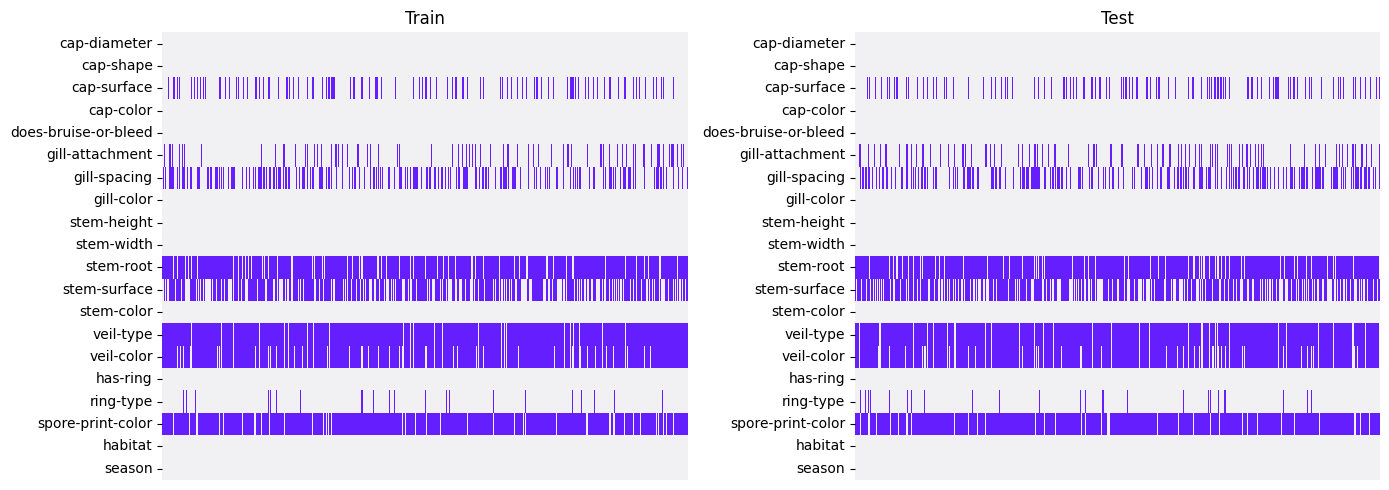

In [5]:
cmap = sns.light_palette('#651FFF', as_cmap=True)

train_null_values = train.sample(100_000).drop(columns=TARGET).isnull().T
test_null_values = test.sample(100_000).isnull().T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.heatmap(train_null_values, cbar=False, cmap=cmap, ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xticks([]) 
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, cmap=cmap, ax=axes[1])
axes[1].set_title('Test')
axes[1].set_xticks([]) 
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

# Feature Engineering

In [6]:
cat_features = test.select_dtypes('object').columns

In [7]:
for feature in cat_features:    
    for df in [train, test]:
        df.loc[df[feature].value_counts(dropna=False)[df[feature]].values < 100, feature] = 'rare'
        df[feature] = df[feature].astype('category')

In [8]:
X = train.drop([TARGET], axis=1)
y = train[TARGET].map({'e': 0, 'p': 1})
X_test = test

In [9]:
encoder = TargetEncoder(cols=['cap-shape', 'veil-type'])
X = encoder.fit_transform(X, y)
X_test = encoder.transform(X_test)

In [10]:
def reduce_mem_usage(dataframe):        
    print('Reducing memory usage')
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        if col_type.name in ['category', 'object']:
            continue

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
            dataframe[col] = dataframe[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            dataframe[col] = dataframe[col].astype(np.float32)
        else:
            dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [11]:
X = reduce_mem_usage(X)
X_test = reduce_mem_usage(X_test)

Reducing memory usage
--- Memory usage before: 187.28 MB
--- Memory usage after: 98.10 MB
--- Decreased memory usage by 47.6%

Reducing memory usage
--- Memory usage before: 124.85 MB
--- Memory usage after: 65.40 MB
--- Decreased memory usage by 47.6%



# Training

In [12]:
def mcc(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = y_pred.round()
    return 'MCC', matthews_corrcoef(y_true, y_pred)

In [13]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                eval_metric=mcc,
                verbose=ES_LOG_STEPS
            )
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs            
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            score = matthews_corrcoef(y_val, np.argmax(y_pred_probs, axis=1))
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'\n--- Fold {fold_idx + 1} - MCC: {score:.6f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_pred_probs, np.mean(scores))
        print(f'------ Average MCC: {np.mean(scores):.6f} ± {np.std(scores):.6f}\n\n')
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_pred_probs, score):
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
        sub[TARGET] = np.argmax(test_pred_probs, axis=1)
        sub[TARGET] = sub[TARGET].map({0: 'e', 1: 'p'})
        sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)

In [14]:
params = {
    # Reference: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense
    'grow_policy': 'depthwise', 
    'n_estimators': 5000, 
    'random_state': SEED,
    'n_jobs': 4,
    'verbosity': 0,
    'max_depth': 20, 
    'reg_lambda': 0.27,
    'min_child_weight': 4.952710346179816, 
    'subsample': 0.953, 
    'colsample_bytree': 0.7539110455959812, 
    'tree_method': 'hist',
    'enable_categorical': True, 
    'gamma': 0,
    'early_stopping_rounds': ES_ROUNDS
}

model = XGBClassifier(**params)
trainer = Trainer(model)
trainer.fit_predict(X, y, X_test)

Training XGBClassifier

[0]	validation_0-logloss:0.44509	validation_0-MCC:0.97282
[50]	validation_0-logloss:0.03801	validation_0-MCC:0.98404
[99]	validation_0-logloss:0.03986	validation_0-MCC:0.98389

--- Fold 1 - MCC: 0.972817


[0]	validation_0-logloss:0.44491	validation_0-MCC:0.97353
[50]	validation_0-logloss:0.03699	validation_0-MCC:0.98482
[99]	validation_0-logloss:0.03896	validation_0-MCC:0.98439

--- Fold 2 - MCC: 0.973526


[0]	validation_0-logloss:0.44505	validation_0-MCC:0.97305
[50]	validation_0-logloss:0.03821	validation_0-MCC:0.98403
[100]	validation_0-logloss:0.04014	validation_0-MCC:0.98374

--- Fold 3 - MCC: 0.973051


[0]	validation_0-logloss:0.44486	validation_0-MCC:0.97359
[50]	validation_0-logloss:0.03795	validation_0-MCC:0.98416
[100]	validation_0-logloss:0.03972	validation_0-MCC:0.98404

--- Fold 4 - MCC: 0.973594


[0]	validation_0-logloss:0.44482	validation_0-MCC:0.97369
[50]	validation_0-logloss:0.03814	validation_0-MCC:0.98439
[100]	validation_0-logloss:0.0400